# WIP

### reference: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
from scipy.stats import multivariate_normal
from scipy.stats import norm
from numpy import random as rd
from scipy import stats

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_3d(fn, tit):
    fig = plt.figure()
    ax = fig.gca(projection='3d')


    mus, var, z = axes3d.get_test_data(0.02)

    mus = (mus + 30) / 12
    var = (var + 30) / 12
    x = mus[0,:]
    y = var[:,0]
    for i in range(len(mus)):
        for j in range(len(var)):
            z[i][j] = fn(x[i], y[j])   
    
    tmp = np.amax(z) * 1.1
    ax.plot_surface(mus, var, z, cmap=cm.coolwarm, alpha=0.3)
    cset = ax.contour(mus, var, z, zdir='z', offset=tmp, cmap=cm.coolwarm)
    cset = ax.contour(mus, var, z, zdir='x', offset=-5, cmap=cm.coolwarm)
    cset = ax.contour(mus, var, z, zdir='y', offset=5, cmap=cm.coolwarm)

    ax.set_xlabel('X')
    ax.set_xlim((-5, 5))
    ax.set_ylabel('Y')
    ax.set_ylim((-5, 5))
    ax.set_zlabel('Z')
    ax.set_zlim((0, tmp))
    ax.set_title(tit)

    plt.show()
    

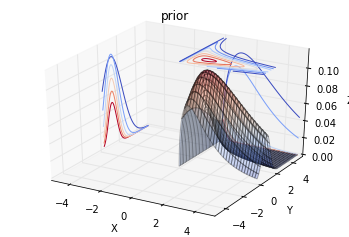

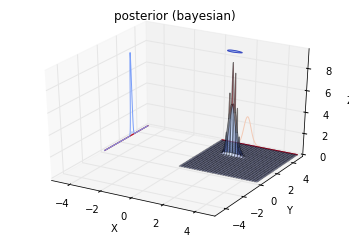

In [28]:
mu = 3
var = 0.5
sig = np.sqrt(var)
N = 100
y = rd.normal(mu, sig, N)

# prior 
mup = 10
lap = 10

# hyperparameters
mu0 = 1
k0 = 1
a0 = 1
b0 = 0.4

def posterior(mu0, k0, a0, b0, n):
    x = y[0:n]
    muml = np.sum(x) / n
    mun = (k0 * mu0 + n * muml) / (k0 + n)
    kn = k0 + n
    an = a0 + n / 2.0
    bn = b0 + 0.5 * np.sum((x - muml) ** 2) + (k0 * n * ((muml - mu0) ** 2)) / (2 * (k0 + n))
    return mun, kn, an, bn


mun, kn, an, bn = posterior(mu0, k0, a0, b0, len(y))


def Zng(mu0, k0, a0, b0):
    '''Computes the normalization constant of the normal-gamma dist'''
    ft = sp.special.gamma(a0) / (b0 **  a0)
    return ft * ((2.0 * np.pi) / k0) ** (0.5)
    
    
def norm_gamma(x, la, mu0, k0, a0, b0):
    zng = Zng(mu0, k0, a0, b0)
    a = la ** (a0 - 0.5)
    return (1.0 / zng) * a * np.exp(- (la / 2.0) * (k0 * ((x - mu0) ** 2) + 2.0 * b0))


def q(x, la):
    return norm_gamma(x, la, mu0, k0, a0, b0)

q_vec = np.vectorize(q)
    
def draw_q(n):
    lambdas = rd.gamma(a0, b0, n)
    mus = []
    for l in lambdas : 
        mus.append(rd.normal(mu0, 1.0 / (k0 * l)))
    return mus, lambdas
        
def likelihood(mu, la):
    n = len(y)
    a = 1.0 / ((2.0 * np.pi) ** (n / 2.0))
    a = a * (la ** (n / 2.0))
    return a * np.exp((- la / 2.0) * np.sum((y - mu) ** 2))

like_vec = np.vectorize(likelihood)

def pt(mus, las):
    return like_vec(mus, las) * q_vec(mus, las)
    
def pz(x, la): 
    return norm_gamma(x, la, mun, kn, an, bn)

def comp_w(n):
    mus, las = draw_q(n)
    w = pt(mus, las) / q_vec(mus, las)
    den = np.sum(w)
    w = w / den
    assert (abs(np.sum(w) - 1) < 1e-5)
    return mus, las, w

plot_3d(q, 'prior')
plot_3d(pz, 'posterior (bayesian)')


79611


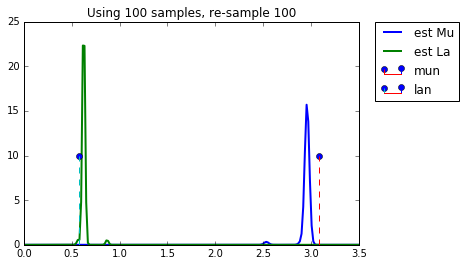

In [127]:
Nexp = [100]
Nrem = [100]

# seed = rd.randint(100000)
seed = 79611
print (seed)
rd.seed(seed)

for k in range(len(Nexp)):
    n = Nexp[k]
    r = Nrem[k]
    mus, las, w = comp_w(n)
    accu = np.copy(w)
    
    for i in range(1, n):
        accu[i] += accu[i - 1]
    
    samp_mu = []
    samp_la = []
    for i in range(r):
        index = np.searchsorted(accu, rd.uniform())
        samp_mu.append(mus[index])
        samp_la.append(las[index])
    
    # print (samp_mu, samp_la)
    
    x = np.linspace(0, 3.5, 200)
    kernel = stats.gaussian_kde(samp_mu)
    plt.plot(x, kernel(x), label='est Mu', lw=2)
    kernel = stats.gaussian_kde(samp_la)
    plt.plot(x, kernel(x), label='est La', lw=2)
    plt.stem([mun], [10], '--', label='mun')
    plt.stem([bn / an], [10], '--', label='lan')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Using %d samples, re-sample %d' % (n, r))
    plt.show()

(120, 120)
(120, 120)
(120, 120)


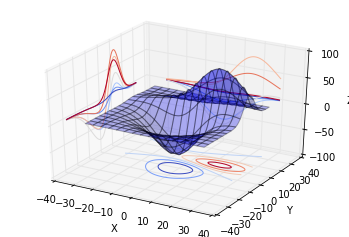

In [3]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
print (X.shape)
print (Y.shape)
print (Z.shape)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()